In [1]:
#pip install -U langchain_community langchain-openai langchain-experimental langchain langgraph

### LLM

We'll use the Mistral API and `Codestral` instruct model, which support tool use!

In [13]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [14]:
from langchain.globals import set_debug

set_debug(True)

## Code Generation

Test with structured output.

In [15]:
# Select LLM
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

llm = OllamaFunctions(model="codellama", format="json", temperature=0)

In [16]:
# Prompt 
test_gen_prompt = PromptTemplate.from_template((
            """You are a coding assistant writing test which throw an exception for every failed test for Test Driven Development. Ensure any code you provide can be executed with all required imports and variables \n
            defined. Structure your answer: 1) a prefix describing the test, 2) the imports, 3) the functioning test code block.
            \n Human: {question}
            AI: """))

code_gen_prompt = PromptTemplate.from_template((
            """You are a coding assistant. Ensure any code you provide can be executed with all required imports and variables \n
            defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block.
            \n Human: {question}. Include the following test code below the implementation: {tests}
            AI: """))

combined_prompt = PromptTemplate.from_template((
            """You are a coding assistant. Ensure any code or test you provide can be executed with all required imports and variables \n
            defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the tests to check corectness of your solution and invocation of these tests, 4) the functioning code block.
            \n Human: {question}
            AI: """))

In [17]:
# Data model
class test_code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    test: str = Field(description="Test code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."

structured_llm = llm.with_structured_output(test_code)
#test_gen_chain = test_gen_prompt | structured_llm

In [18]:
#code_gen_chain = code_gen_prompt | structured_llm
combined_chain = combined_prompt | structured_llm

In [19]:
question = "Write a function for fibonacci."

In [21]:
# Test
llm_response = combined_chain.invoke(question)
print(llm_response.imports)
print(llm_response.code)
print(llm_response.test)
print(llm_response.description)

[chain/start] [chain:RunnableSequence] Entering Chain run with input:
{
  "input": "Write a function for fibonacci."
}
[chain/start] [chain:RunnableSequence > prompt:PromptTemplate] Entering Prompt run with input:
{
  "input": "Write a function for fibonacci."
}
[chain/end] [chain:RunnableSequence > prompt:PromptTemplate] s] Exiting Prompt run with output:
[outputs]
[llm/start] [chain:RunnableSequence > llm:OllamaFunctions] Entering LLM run with input:
{
  "prompts": [
    "Human: You are a coding assistant. Ensure any code or test you provide can be executed with all required imports and variables \n\n            defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the tests to check corectness of your solution and invocation of these tests, 4) the functioning code block.\n            \n Human: Write a function for fibonacci.\n            AI:"
  ]
}
[llm/end] [chain:RunnableSequence > llm:OllamaFunctions] [6.87s] Exiting LLM run with output:
{
 

In [117]:
#print(code_gen_chain.invoke({"question":question, "tests": tests.test}))

In [22]:
from typing import Annotated
from typing import Dict, TypedDict, List
from langgraph.graph.message import AnyMessage, add_messages

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: Annotated[list[AnyMessage], add_messages]
    generation: str
    iterations: int

## Graph

In [28]:
from operator import itemgetter
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

### Parameters
max_iterations = 3

### Nodes
def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # Solution
    code_solution = combined_chain.invoke(messages)
    messages += [
        (
            "assistant",
            f"Here is my attempt to solve the problem: {code_solution.prefix} \n Imports: {code_solution.imports} \n Test: {code_solution.test} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    prefix = code_solution.prefix
    imports = code_solution.imports
    test = code_solution.test
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test. Here is the error: {e}. Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, test and code block:")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        combined_code = f"{imports}\n{code}\n{test}"
        # Use a shared scope for exec
        global_scope = {}
        exec(combined_code, global_scope)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test or unit test: {e}) Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, test and code block:")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

### Conditional edges

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

### Utilities

import uuid 

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [29]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph

builder = StateGraph(GraphState)

# Define the nodes
builder.add_node("generate", generate)  # generation solution
builder.add_node("check_code", code_check)  # check code

# Build graph
builder.set_entry_point("generate")
builder.add_edge("generate", "check_code")
builder.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

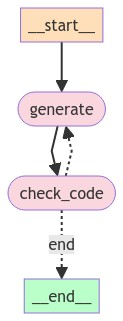

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [128]:
!pip install Pillow

In [31]:
import uuid
_printed = set()
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

question = "Write a Python program that prints 'Hello, World!' to the console."
events = graph.stream(
    {"messages": [("user", question)], "iterations": 0}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

event['generation']

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "Write a Python program that prints 'Hello, World!' to the console."
    ]
  ],
  "iterations": 0
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "Write a Python program that prints 'Hello, World!' to the console."
    ]
  ],
  "iterations": 0
}
[chain/end] [chain:LangGraph > chain:__start__] s] Exiting Chain run with output:
{
  "messages": [
    [
      "user",
      "Write a Python program that prints 'Hello, World!' to the console."
    ]
  ],
  "iterations": 0
}
================================ Human Message =================================

Write a Python program that prints 'Hello, World!' to the console.
[chain/start] [chain:LangGraph > chain:generate] Entering Chain run with input:
[inputs]
---GENERATING CODE SOLUTION---
[chain/start] [chain:LangGraph > chain:generate > chain:RunnableSequence]

test_code(prefix="Print 'Hello, World!' to the console.", imports='', code="print('Hello, World!')", test='', description='Schema for code solutions to questions about LCEL.')

`Trace:`

https://smith.langchain.com/public/53bcdaab-e3c5-4423-9908-c44595325c38/r

In [32]:
_printed = set()
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

question = '''I want to vectorize a function

        frame = np.zeros((out_h, out_w, 3), dtype=np.uint8)
        for i, val1 in enumerate(rows):
            for j, val2 in enumerate(cols):
                for j, val3 in enumerate(ch):
                    # Assuming you want to store the pair as tuples in the matrix
                    frame[i, j, k] = image[val1, val2, val3]

        out.write(np.array(frame))

with a simple numpy function without using for loop'''

events = graph.stream(
    {"messages": [("user", question)], "iterations": 0}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

[chain/start] [chain:LangGraph] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "I want to vectorize a function\n\n        frame = np.zeros((out_h, out_w, 3), dtype=np.uint8)\n        for i, val1 in enumerate(rows):\n            for j, val2 in enumerate(cols):\n                for j, val3 in enumerate(ch):\n                    # Assuming you want to store the pair as tuples in the matrix\n                    frame[i, j, k] = image[val1, val2, val3]\n\n        out.write(np.array(frame))\n\nwith a simple numpy function without using for loop"
    ]
  ],
  "iterations": 0
}
[chain/start] [chain:LangGraph > chain:__start__] Entering Chain run with input:
{
  "messages": [
    [
      "user",
      "I want to vectorize a function\n\n        frame = np.zeros((out_h, out_w, 3), dtype=np.uint8)\n        for i, val1 in enumerate(rows):\n            for j, val2 in enumerate(cols):\n                for j, val3 in enumerate(ch):\n                    # Assuming you want t

KeyError: 'tool'

Trace w/ good example of self-correction:

https://smith.langchain.com/public/b54778a0-d267-4f09-bc28-71761201c522/r

In [ ]:
_printed = set()
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

question = """Create a Python program that allows two players to play a game of Tic-Tac-Toe. The game should be played on a 3x3 grid. The program should:

- Allow players to take turns to input their moves.
- Check for invalid moves (e.g., placing a marker on an already occupied space).
- Determine and announce the winner or if the game ends in a draw.

Requirements:
- Use a 2D list to represent the Tic-Tac-Toe board.
- Use functions to modularize the code.
- Validate player input.
- Check for win conditions and draw conditions after each move."""

events = graph.stream(
    {"messages": [("user", question)], "iterations": 0}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

Trace w/ good example of failure to correct:

https://smith.langchain.com/public/871ae736-2f77-44d4-b0da-a600d8f5377d/r